In [1]:
# %matplotlib inline  
from __init__ import *
import core.steps as steps
from core import data_store as ds
from core.common.ds_utils import print_ds_items_info
from core.evaluation.retrieval_perfomance import extract_perfomances_from_arr
from core.common.path_helper import DataStoreHelper
import math, os
%load_ext autoreload
%autoreload 2

In [2]:
ds_helper=DataStoreHelper(r'C:\data\computation\brodatz')

# Plot search perfomance wtih respect to pq params

In [3]:
n_nearest=25
n_nearest_cutoffs=[1,5,10,25]

In [4]:
K_arr = [2 ** i for i in [4,5,6,7,8]]
m_arr = [m for m in [1, 2, 4, 8, 16]]
pq_params_arr = [{'n_clusters': K, 'n_quantizers': m} for K in K_arr for m in m_arr]

bytes_free=1 << 34
imi_pq_params_arr = [{'n_clusters': K, 'n_quantizers': m} for K in K_arr for m in m_arr if 4 * K ** m < bytes_free]
imi_pq_params_arr.remove({'n_clusters': 128, 'n_quantizers': 4})

In [80]:
def plot_pq_search_params_perfomance(search_type, descriptor_name, pq_params_arr, perfomance_type, n_nearest_cutoffs, save_to_file=False):
    subplotname__label__x__y = {}
    label__kwargs={}
    for n_nearest in n_nearest_cutoffs:
        label__x__y=subplotname__label__x__y.setdefault(n_nearest,{})
        for pq_params in pq_params_arr:
            perfomances_ds = ds_helper.pq_search_perfomances_ds(search_type, descriptor_name, pq_params)
            perfomance_arr = ds_helper.perfomance_arr(perfomances_ds)
            y = extract_perfomances_from_arr(perfomance_arr, perfomance_type)[n_nearest-1]
            label = pq_params['n_quantizers']
            x__y = label__x__y.setdefault(label, {})
#             x = pq_params['n_clusters']
            x = pq_params['n_quantizers']*math.log2(pq_params['n_clusters'])
#             x = pq_params['n_quantizers']*pq_params['n_clusters']
            x__y[x] = y
            label__kwargs[label]={'linestyle':'dashed'}

        original_ex_search_perfomances_ds=ds_helper.ex_search_perfomances_ds(descriptor_name)
        original_ex_search_perfomance_arr=ds_helper.perfomance_arr(original_ex_search_perfomances_ds)
        y=extract_perfomances_from_arr(original_ex_search_perfomance_arr, perfomance_type)[n_nearest-1]
        label__x__y[0]={ pq_params['n_quantizers']*math.log2(pq_params['n_clusters']):y for pq_params in pq_params_arr}
#         label__x__y[0]={ pq_params['n_quantizers']*pq_params['n_clusters']:y for pq_params in pq_params_arr}
#         label__x__y[0]={pq_params['n_clusters']:y for pq_params in pq_params_arr}
        label__kwargs[0]={'linewidth':3.0}
       
    subplotvalue__props={}
    for n_nearest in n_nearest_cutoffs:
        break
        x=32
        y_up=subplotname__label__x__y[n_nearest][2][32]
        y_down=subplotname__label__x__y[n_nearest][1][32]
        
        if y_up-y_down<0.1:
            continue
#         annotate={'s':'df', 'xy':(x,y) ,'xytext':(x,y_text),'arrowprops':dict(facecolor='black', shrink=0.5)}
#         subplotvalue__props[n_nearest]={'annotate':annotate}
        annotate1={'s':'.', 'xy':(x,y_up-0.01) ,'xytext':(x,y_down),'arrowprops':dict(facecolor='black',width=1)}
        annotate2={'s':'.', 'xy':(64,y_down) ,'xytext':(32,y_down+0.005),'arrowprops':dict(facecolor='black',width=1)}
        
        if search_type=='imi':
            text1={'x':x+10,'y':(y_up+y_down)/2,'s':'в $k^m$ раз больше памяти','fontdict':dict(fontsize=12),
              'bbox':dict(facecolor='white', alpha=0.8)}
            text2={'x':32+10,'y':y_down-0.15,'s':'в 2 раза медленнее квантизация\nв $2^m$ раз больше памяти','fontdict':dict(fontsize=12),
              'bbox':dict(facecolor='white', alpha=0.8)}
        else:
            text1= {'x':x+10,'y':(y_up+y_down)/2,'s':'в 2 раза больше памяти\nв 2 раза медленнее поиск','fontdict':dict(fontsize=12),
              'bbox':dict(facecolor='white', alpha=0.8)}
            text2={'x':32+10,'y':y_down-0.1,'s':'в 2 раза медленнее квантизация','fontdict':dict(fontsize=12),
              'bbox':dict(facecolor='white', alpha=0.8)}
        texts=[text1,text2]
        subplotvalue__props[n_nearest]={'annotates':[annotate1, annotate2], 'texts':[text1,text2]}
#         subplotvalue__props[n_nearest]={'annotates':[annotate1,annotate2]}
#         arrow={'x':x,'y':y_text,'dx':0,'dy':0.1, 'width':1}
#         subplotvalue__props[n_nearest]={'arrow':arrow}
    
    if save_to_file:
        plot_path=ds_helper.pq_search_perfomances_plot_path(search_type, descriptor_name, perfomance_type)
    else:
        plot_path=None
    label_callback=lambda label: 'original' if label==0 else 'm = {}'.format(label)
   
    steps.plotting_step3(subplotname__label__x__y, 'n_nearest: ', label_callback, 'k', perfomance_type, 
                         save_to_file=plot_path, label__kwargs=label__kwargs, subplotvalue__props=subplotvalue__props,
                        figsize=dict(width=17, height=17))

In [81]:
plot_pq_search_params_perfomance('adc', 'histograms', pq_params_arr, 'precision', n_nearest_cutoffs)

In [82]:
plot_pq_search_params_perfomance('adc', 'histograms', pq_params_arr, 'precision', n_nearest_cutoffs, save_to_file=True)

In [64]:
plot_pq_search_params_perfomance('adc', 'histograms', pq_params_arr, 'recall', n_nearest_cutoffs)

In [26]:
plot_pq_search_params_perfomance('imi', 'histograms', imi_pq_params_arr, 'precision', n_nearest_cutoffs)

ERROR! Session/line number was not unique in database. History logging moved to new session 730
0.0 1.0
256.0 1.0
256.0 1.0


C:\Anaconda3\lib\site-packages\matplotlib\ticker.py:2039: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


0.0 1.0
256.0 1.0
256.0 1.0
0.0 1.0
256.0 1.0
256.0 1.0
0.0 1.0
256.0 1.0
256.0 1.0


In [135]:
plot_pq_search_params_perfomance('sdc', 'histograms', pq_params_arr, 'precision', n_nearest_cutoffs)
plot_pq_search_params_perfomance('sdc', 'histograms', pq_params_arr, 'recall', n_nearest_cutoffs)
plot_pq_search_params_perfomance('sdc', 'histograms', pq_params_arr, 'mAP', n_nearest_cutoffs)

{}
{}
{}


In [14]:
plot_pq_search_params_perfomance('adc', 'histograms', pq_params_arr, 'precision', n_nearest_cutoffs)
plot_pq_search_params_perfomance('adc', 'histograms', pq_params_arr, 'recall', n_nearest_cutoffs)
plot_pq_search_params_perfomance('adc', 'histograms', pq_params_arr, 'mAP', n_nearest_cutoffs)

In [16]:
plot_pq_search_params_perfomance('adc', 'bovwproductbincounts_pq-64-4', pq_params_arr, 'precision', n_nearest_cutoffs)
plot_pq_search_params_perfomance('adc',  'bovwproductbincounts_pq-64-4', pq_params_arr, 'recall', n_nearest_cutoffs)
plot_pq_search_params_perfomance('adc',  'bovwproductbincounts_pq-64-4', pq_params_arr, 'mAP', n_nearest_cutoffs)

In [11]:
plot_pq_search_params_perfomance('adc', 'histograms', pq_params_arr, 'precision', n_nearest_cutoffs,True)
plot_pq_search_params_perfomance('adc', 'histograms', pq_params_arr, 'recall', n_nearest_cutoffs,True)
plot_pq_search_params_perfomance('adc', 'histograms', pq_params_arr, 'mAP', n_nearest_cutoffs,True)

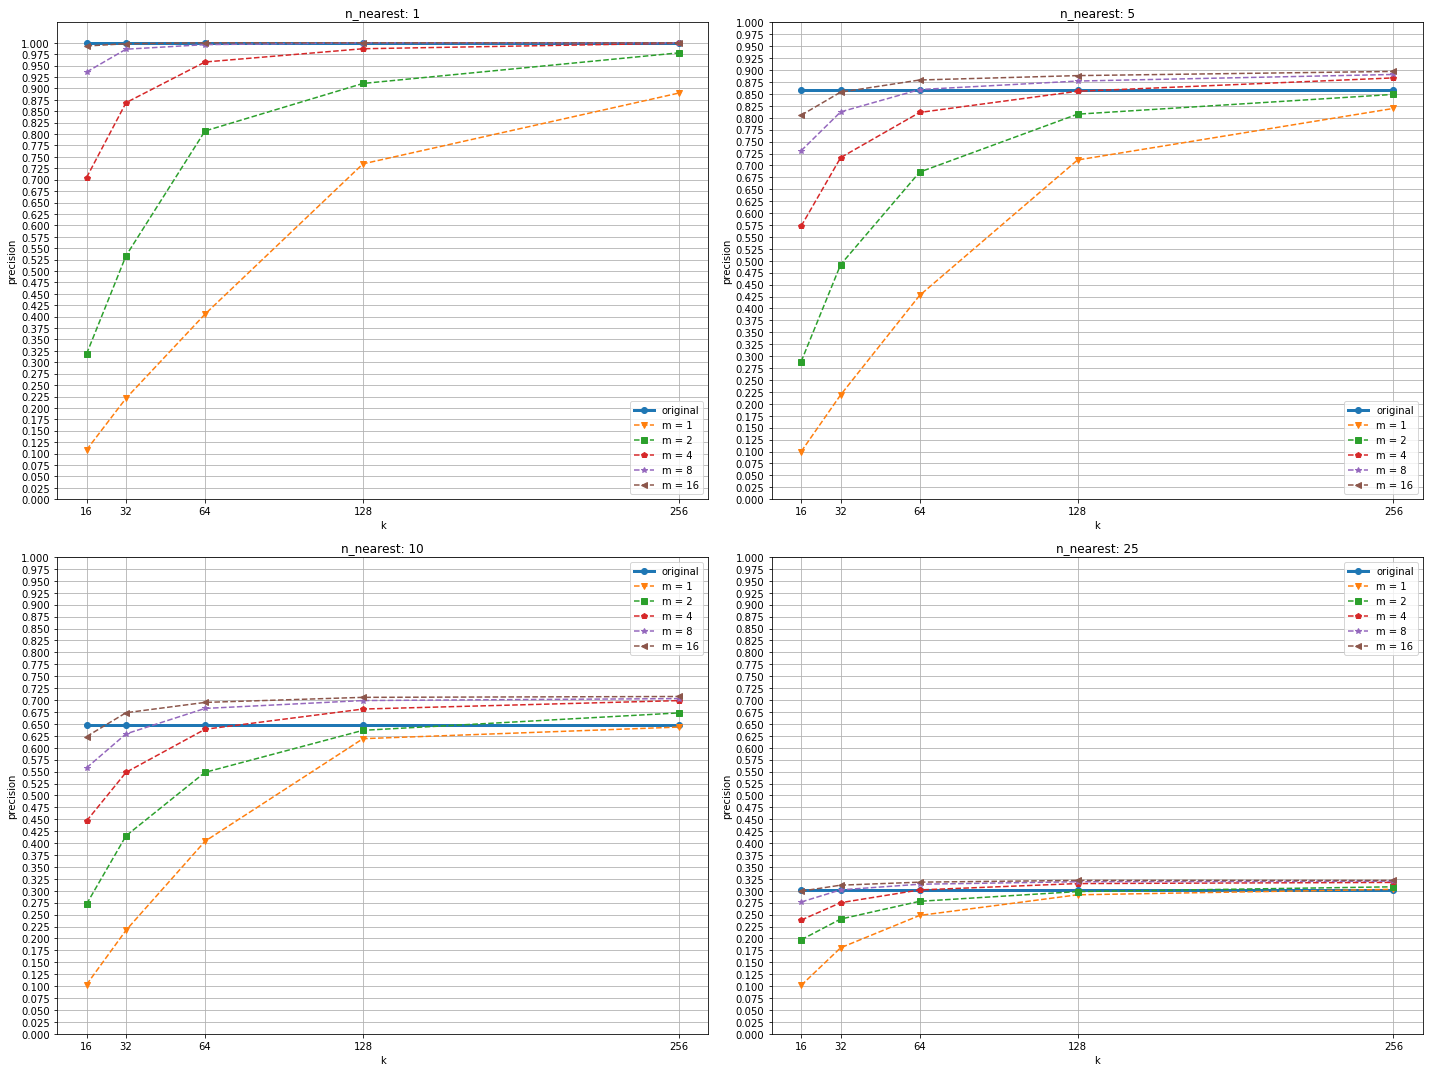

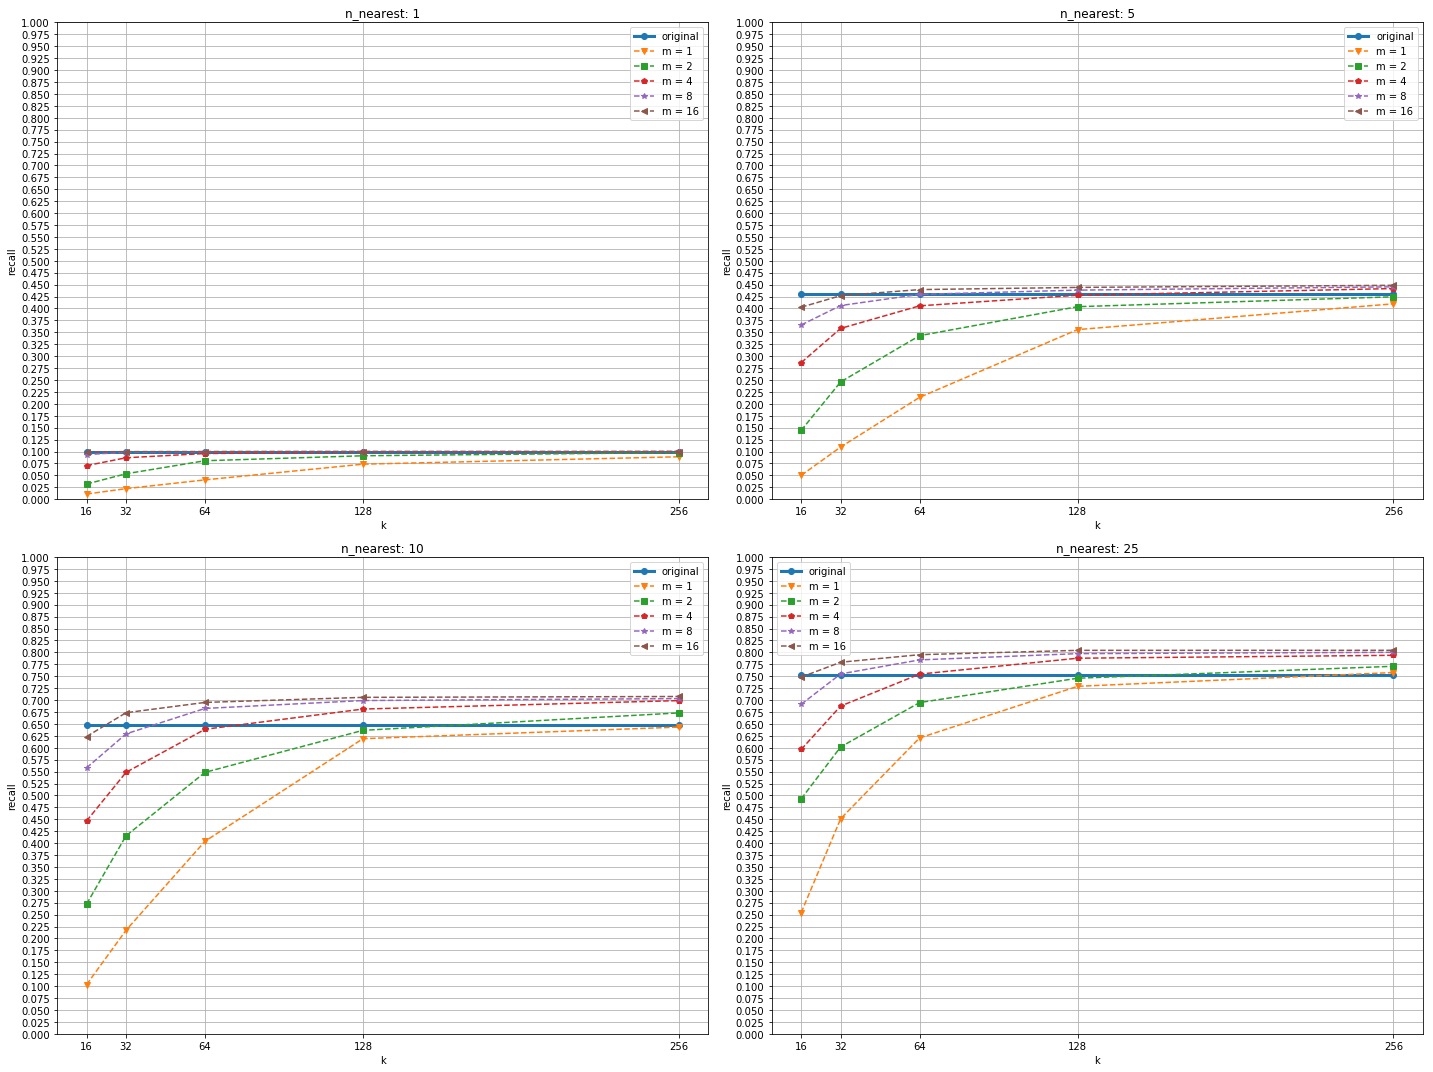

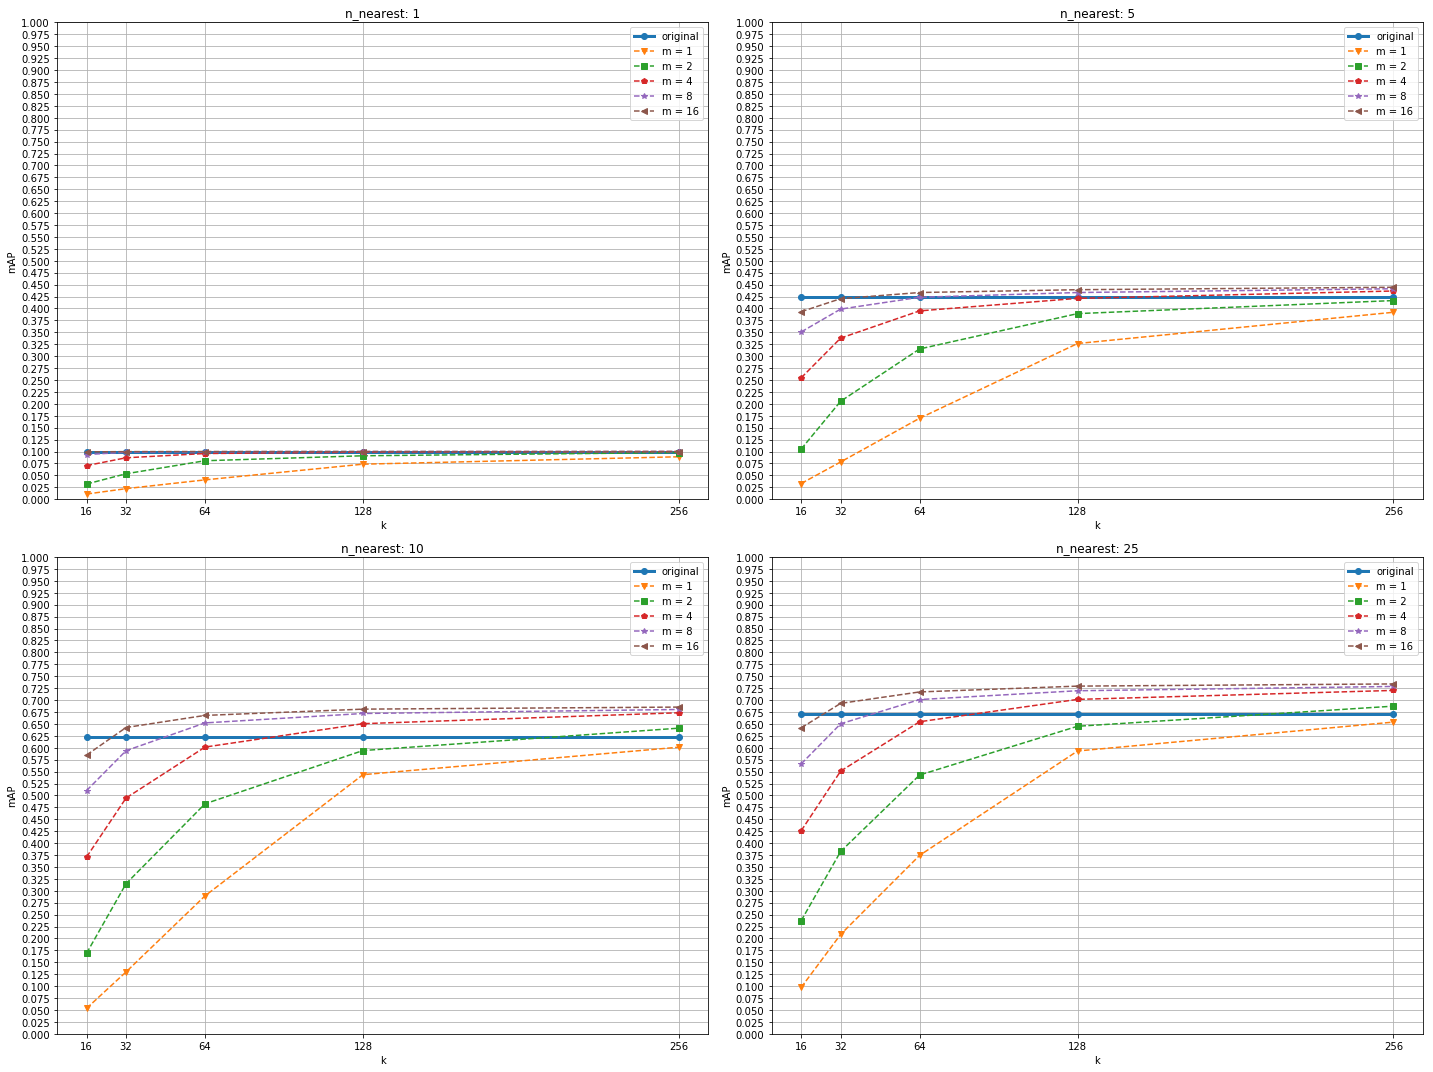

In [6]:
plot_pq_search_params_perfomance('sdc', 'histograms', pq_params_arr, 'precision', n_nearest_cutoffs)
plot_pq_search_params_perfomance('sdc', 'histograms', pq_params_arr, 'recall', n_nearest_cutoffs)
plot_pq_search_params_perfomance('sdc', 'histograms', pq_params_arr, 'mAP', n_nearest_cutoffs)

In [ ]:
plot_pq_search_params_perfomance('sdc', 'glcms', pq_params_arr, 'precision', n_nearest_cutoffs)
plot_pq_search_params_perfomance('sdc', 'lbphistograms', pq_params_arr, 'precision', n_nearest_cutoffs)

In [ ]:
plot_pq_search_params_perfomance('adc', 'glcms', pq_params_arr, 'precision', n_nearest_cutoffs)
plot_pq_search_params_perfomance('adc', 'glcms', pq_params_arr, 'recall', n_nearest_cutoffs)

In [6]:
plot_pq_search_params_perfomance('imi', 'histograms', imi_pq_params_arr, 'precision', n_nearest_cutoffs)
plot_pq_search_params_perfomance('imi', 'histograms', imi_pq_params_arr, 'recall', n_nearest_cutoffs)
plot_pq_search_params_perfomance('imi', 'histograms', imi_pq_params_arr, 'mAP', n_nearest_cutoffs)

In [286]:
descriptor_names=['histograms', 'lbphistograms', 'glcms']
choosen_bovwproductbincounts_pq_params= [{'n_clusters': K, 'n_quantizers': m} for K,m in [(64,4),(128,1),(16,1)]]
descriptor_names+=ds_helper.bovw_descriptors_names('bovwproductbincounts',choosen_bovwproductbincounts_pq_params)

descriptor_names=['histograms']

In [298]:
perfomance_names=['precision', 'recall', 'mAP']

In [462]:
for descriptor_name in descriptor_names:
    for perfomance_name in perfomance_names:
        plot_pq_search_params_perfomance('adc', descriptor_name, pq_params_arr, perfomance_name, n_nearest_cutoffs, save_to_file=True)
        plot_pq_search_params_perfomance('sdc', descriptor_name, pq_params_arr, perfomance_name, n_nearest_cutoffs, save_to_file=True)
#         plot_pq_search_params_perfomance('imi', descriptor_name, imi_pq_params_arr, perfomance_name, n_nearest_cutoffs, save_to_file=True)

In [463]:
for descriptor_name in descriptor_names:
    for perfomance_name in perfomance_names:
        plot_pq_search_params_perfomance('imi', descriptor_name, imi_pq_params_arr, perfomance_name, n_nearest_cutoffs, save_to_file=True)